# Lecture 3: Neural Networks
Let's look at how a basic neural network is implemented in PyTorch. We won't worry about training it yet: we just want to get an idea of its structure.

In [1]:
import torch
from torch import nn

In [2]:
fc = nn.Linear(in_features=4, out_features=2, bias=True)

Above, I've set `in_features` to 4, meaning that the layer accepts input with 4 features. `out_features` is set to 2, which, as you might expect, means that the model will give us outputs with two features. `bias` means that the layer has a bias vector: a $\beta_0$. 

Our `fc` layer has been initialized with random weights. Let's give it some input. 

In [3]:
input = torch.ones(4)    
print("Input: ", input)
with torch.no_grad():
    print("Output: ", fc(input))

Input:  tensor([1., 1., 1., 1.])
Output:  tensor([0.2569, 0.1028])


This layer is not doing anything mysterious. Let's inspect its (again, randomly initialized) parameters and bias vector:

In [4]:
fc.weight

Parameter containing:
tensor([[ 0.3534, -0.2874, -0.0886, -0.0951],
        [ 0.1008,  0.4442, -0.0789, -0.2011]], requires_grad=True)

In [5]:
fc.bias

Parameter containing:
tensor([ 0.3745, -0.1623], requires_grad=True)

When we call `fc`, this is what's happening under the hood:

In [6]:
with torch.no_grad(): 
    manual_output = fc.weight @ input + fc.bias
    output = fc(input)

print("Manually computed output: ", manual_output)
print("Equivalent? ", torch.allclose(manual_output, output))

Manually computed output:  tensor([0.2569, 0.1028])
Equivalent?  True


(In case you haven't seen this before, `@` is the matmul operator in Python.)

We can make an MLP by stacking `Linear` layers on top of each other with activation functions. `torch` provides the `Sequential` object which makes this easy: 

In [7]:
mlp = nn.Sequential(
    nn.Linear(4, 8),
    nn.Sigmoid(),
    nn.Linear(8, 4)
)

This MLP projects our 4D input up to 8 dimensions, applies the sigmoid function, then projects it back down to 4 dimensions. This is similar to what you'll see in the MLP layers of an LLM. 

In [8]:
input = torch.ones(4)
with torch.no_grad(): 
    print(mlp(input))

tensor([ 0.5956, -0.0824,  0.1664, -0.4094])


## Playing with weights

It can be really hard to wrap your head around even a small MLP given their complexity. Below, I've created a small exercise to help you visualize what is going on in a 2d neural network. 

In [9]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import torch.nn.functional as F

Run this cell to visualize the inputs.

<Axes: xlabel='x', ylabel='y'>

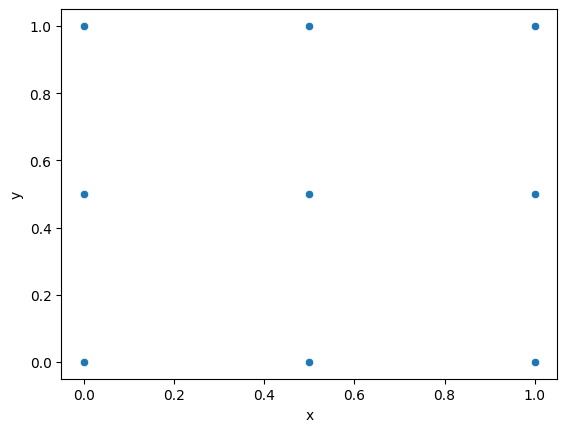

In [10]:
inputs = torch.tensor(
    [
        [0.0, 0.0], 
        [0.0, 1.0],
        [1.0, 0.0], 
        [1.0, 1.0], 
        [0.5, 0.5], 
        [0.5, 1.0],
        [1.0, 0.5],
        [0.5, 0.0], 
        [0.0, 0.5]
    ]
)

# plot our inputs 
sns.scatterplot(
    data=pd.DataFrame(inputs, columns=["x", "y"]),
    x="x", 
    y="y"
)

Now, run this cell to visualize what happens when we pass these inputs through a single layer of a neural network. This layer is equivalent to `nn.Linear(2, 2, bias=True)` followed by sigmoid. I've left the weights set to $I$, so you should try editing them (and the bias vector) to see what kinds of functions you can create. In the scatterplot, each point is annotated with the input values to make things a little clearer.  

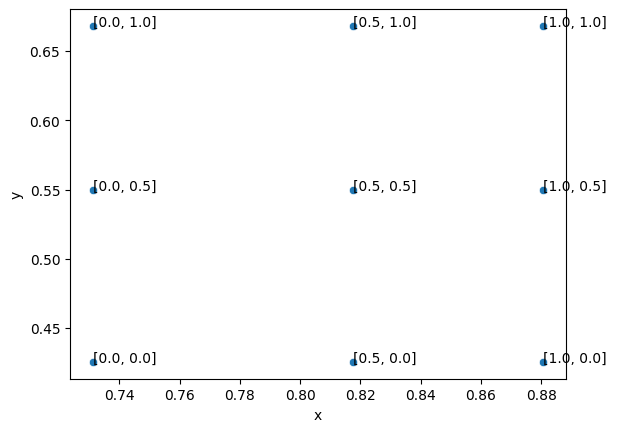

In [11]:
weights = torch.tensor(
    [
        [1.0, 0.0],   # Edit these values
        [0.0, 1.0]    # And these values
    ]
)

bias = torch.tensor(
    [1.0, -0.3]        # Try changing these as well
)[:, None]

output = (weights @ inputs.T + bias)
output = F.sigmoid(output) # Try changing this activation function too!
output = pd.DataFrame(output.T, columns=["x", "y"])
output["input"] = [str(i) for i in inputs.tolist()]


# Run the cell to visualize
sns.scatterplot(
    data=output, 
    x="x", 
    y="y",
)

for line in range(0, output.shape[0]):
    plt.text(
        output["x"][line], 
        output["y"][line], 
        output["input"][line],
        ha="left"
    )
plt.show()

Here's a very simple example of model training. We create some training data by generating random 2d inputs. We then create labels by first generating a random 2x2 matrix and then multiplying it by our training data. If all goes well, our model (one linear layer) will have weights that are very close to this random 2x2 matrix. 

In [99]:
inputs = torch.randn((100000, 2))
rand = torch.randn((2, 2))
labels = (rand @ inputs.T).T

model = nn.Linear(2, 2, bias=False)

optimizer = torch.optim.Adagrad(model.parameters())
batch_size = 10
epochs = 3
print("Random matrix used to generate labels:\n", rand)
print("Initial model weights:\n", model.weight.detach())
print("\n")
for epoch in range(epochs):
    for i in range(0, inputs.shape[0], batch_size):
        optimizer.zero_grad()
        batch = inputs[i:i+batch_size]
        preds = model(batch)
        loss = F.mse_loss(preds, labels[i:i+batch_size])
        loss.backward() 
        optimizer.step()
    print(f"Model weights at epoch {epoch}:\n", model.weight.detach())
    print("\n")

Random matrix used to generate labels:
 tensor([[ 1.3403, -0.9533],
        [-0.4570, -1.5816]])
Initial model weights:
 tensor([[-0.4266, -0.2057],
        [-0.4967,  0.7037]])


Model weights at epoch 0:
 tensor([[ 0.9432, -0.9361],
        [-0.4543, -0.7945]])


Model weights at epoch 1:
 tensor([[ 1.2017, -0.9528],
        [-0.4556, -1.1805]])


Model weights at epoch 2:
 tensor([[ 1.2910, -0.9534],
        [-0.4563, -1.3704]])




In [100]:
rand

tensor([[ 1.3403, -0.9533],
        [-0.4570, -1.5816]])

In [101]:
print(model.weight)

Parameter containing:
tensor([[ 1.2910, -0.9534],
        [-0.4563, -1.3704]], requires_grad=True)
